Plots for learning harmonic functions
with neural networks.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import logging
import os
import pickle
import sys
import warnings
from typing import Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from tqdm.auto import tqdm

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch as t

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [3]:
sys.path.append("..")

import src.experiments.harmonics.bw_loss as bw_loss
from src import utils
from src.experiments.harmonics.data import HypercubeDataModule
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig, HFReg, ActivationT
from src.experiments.harmonics.harmonics import (
    HarmonicFn,
    HarmonicFnConfig,
    HarmonicFnTrainable,
    HarmonicFnTrainableConfig,
)
from src.experiments.harmonics.poly import ChebPoly

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


## Utility code

In [4]:
class CustomCallback(pl.Callback):
    def __init__(self, leave_pbar: bool):
        super().__init__()
        self.pbar = tqdm(leave=leave_pbar)
        self.metric_history: list[dict[str, float]] = []

    def on_train_batch_end(self, trainer: pl.Trainer, *_, **__):
        md = {k: v.item() for k, v in trainer.logged_metrics.items()}
        self.metric_history.append(md)

        self.pbar.update()
        self.pbar.set_description(f"train_mse={md['train_mse']: .6e}")


def train(
    dm: HypercubeDataModule,
    model: pl.LightningModule,
    patience_steps: int,
    leave_pbar: bool = False,
) -> pl.LightningModule:
    patience_lb = patience_steps // max(1, dm.n_train // dm.batch_size)
    cc = CustomCallback(leave_pbar=leave_pbar)
    trainer = pl.Trainer(
        gpus=1,
        deterministic=True,
        logger=False,  # We do custom logging instead.
        log_every_n_steps=1,
        max_epochs=-1,
        callbacks=[
            cc,
            EarlyStopping(
                monitor="train_loss",
                patience=max(patience_lb + 10, int(1.5 * patience_lb)),
                mode="min",
            ),
        ],
        enable_progress_bar=False,
        weights_summary=None,
    )
    trainer.fit(
        model=model,
        datamodule=dm,
    )

    return model, pd.DataFrame(cc.metric_history)


In [5]:
def get_mse(
    model: pl.LightningModule,
    dl: t.utils.data.DataLoader,
) -> t.Tensor:
    return pl.Trainer(enable_progress_bar=False,).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]["test_mse"]


@dataclasses.dataclass(frozen=True)
class LSData:
    ns: np.ndarray
    val_mses: np.ndarray


def run_lstsq_exp(
    ns: list[int],
    true_fn: Union[HarmonicFn, ChebPoly],
    estimator: Callable[[np.ndarray, np.ndarray], pl.LightningModule],
    noise_std: float = 0.0,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        dm = HypercubeDataModule(
            fn=true_fn,
            input_dim=true_fn.cfg.input_dim,
            n_train=n_train,
            n_val=1024,
            train_seed=n_train,
            val_seed=-1,
            num_workers=0,
            batch_size=256,
        )
        dm.setup()

        xs_train = dm.train_ds.tensors[0].numpy()
        ys_train = dm.train_ds.tensors[1].numpy()
        
        fn_hat = estimator(
            xs_train,
            ys_train + noise_std * np.random.normal(size=len(ys_train)),
        )

        mse = get_mse(model=fn_hat, dl=dm.val_dataloader())        
        val_mses.append(mse)
    
    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )

def run_nn_exp(
    ns: list[int],
    true_fn: Union[HarmonicFn, ChebPoly],
    net_cfg: FCNetConfig,
    patience_steps: int,
    seed: int = 42,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        dm = HypercubeDataModule(
            fn=true_fn,
            input_dim=true_fn.cfg.input_dim,
            n_train=n_train,
            n_val=1024,
            train_seed=seed,
            val_seed=-1,
            num_workers=0,
            batch_size=256,
        )
        dm.setup()

        pl.seed_everything(seed)
        model = FCNet(
            cfg=dataclasses.replace(
                net_cfg,
                sched_patience=patience_steps // max(1, dm.n_train // dm.batch_size)
                + 1,
            )
        )
        fn_hat, _ = train(
            dm=dm,
            model=model,
            patience_steps=patience_steps,
        )

        mse = get_mse(model=fn_hat, dl=dm.val_dataloader())
        val_mses.append(mse)

    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )


## Run experiments

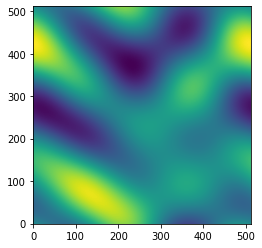

In [6]:
TRUE_HF = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=2,
        num_components=16,
    )
)
TRUE_HF.viz_2d(side_samples=512, pad=(0, 0));

### Manual experiments

In [7]:
dm = HypercubeDataModule(
    fn=TRUE_HF,
    input_dim=TRUE_HF.cfg.input_dim,
    n_train=128,
    n_val=512,
    train_seed=-1,
    val_seed=42,
    num_workers=0,
    batch_size=256,
)

In [11]:
RELU_NET_CFG = FCNetConfig(
    input_dim=2,
    layer_widths=(512, 512, 512, 1),
    act=ActivationT.RELU,
    learning_rate=1e-3,
    sched_patience=200 // max(1, dm.n_train // dm.batch_size) + 1,
    sched_monitor="train_mse",
)

SIN_NET_CFG = FCNetConfig(
    input_dim=2,
    layer_widths=(200, 1),
    act=ActivationT.SIN,
    param_init_std=0.1,
    learning_rate=3e-3,
    sched_patience=100,
    sched_monitor="train_mse",
)

HFT_CFG = HarmonicFnTrainableConfig(
    input_dim=2,
    freq_limit=3,
    num_components=200,
    seed=0,
    learning_rate=3e-3,
    sched_patience=100,
    sched_monitor="train_mse",
)

sin_net = FCNet(SIN_NET_CFG)
hf_trainable = HarmonicFnTrainable(HFT_CFG)

pl.seed_everything(44)
relu_net = FCNet(
    dataclasses.replace(
        RELU_NET_CFG,
        sched_verbose=True,
        high_freq_lambda=1,
        high_freq_freq_limit=2,
        high_freq_mcls_samples=20_000,
    )
)

fn_hat, mh = train(dm=dm, model=relu_net, patience_steps=200, leave_pbar=True)


0it [00:00, ?it/s]

Epoch  3515: reducing learning rate of group 0 to 1.0000e-04.
Epoch  8071: reducing learning rate of group 0 to 1.0000e-05.


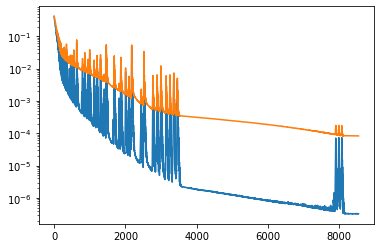

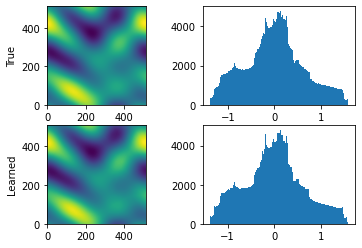

In [12]:
fn_hat.cpu()
mh.train_mse.plot()
mh.val_mse.plot()
plt.yscale("log")
plt.show()

plt.subplot(2, 2, 1)
img = TRUE_HF.viz_2d(side_samples=512, pad=(0, 0), value=0.42)
plt.ylabel("True");

plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128)

plt.subplot(2, 2, 3)
img = fn_hat.viz_2d(side_samples=512, pad=(0, 0), value=0.42)
plt.ylabel("Learned");

plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

In [13]:
print("Train MSE:", get_mse(model=fn_hat, dl=dm.train_dataloader(shuffle=False)))
print("Test MSE:", get_mse(model=fn_hat, dl=dm.val_dataloader()))

print(
    "HF-norm (mcls):",
    bw_loss.high_freq_norm_mcls(
        fn=fn_hat,
        input_dim=fn_hat.cfg.input_dim,
        freq_limit=3,
        n_samples=10_000,
        device=fn_hat.device,
    ),
)
print(
    "HF-norm (dft): ",
    bw_loss.high_freq_norm_dft(
        fn=fn_hat,
        input_dim=fn_hat.cfg.input_dim,
        freq_limit=3,
        side_samples=512,
        device=fn_hat.device,
    ),
)

Train MSE: 3.2378153491663397e-07
Test MSE: 8.29694836284034e-05
HF-norm (mcls): tensor(2.1833e-05, grad_fn=<MeanBackward0>)
HF-norm (dft):  tensor(2.1234e-05, grad_fn=<PowBackward0>)


### Scaled up experiments

In [14]:
# DATA = dict()
with open("data/nn-harmonic-reg-data.pkl", "rb") as f:
    DATA = pickle.load(f)

In [17]:
DATA["relu_reg_mh"] = dm.n_train, mh

In [ ]:
DATA["relu"] = run_nn_exp(
    ns=[50, 100, 200, 400, 800, 1600, 3200, 6400, 10000, 20000, 40000],
    true_fn=TRUE_HF,
    net_cfg=RELU_NET_CFG,
    patience_steps=500,
)

In [14]:
DATA["hf"] = run_lstsq_exp(
    ns=list(range(1, 100)) + [200, 400, 800],
    true_fn=TRUE_HF,
    estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
        xs=xs,
        ys=ys,
        freq_limit=2,
    ),
)

  0%|          | 0/102 [00:00<?, ?it/s]

In [18]:
# import pickle
# with open("data/nn-harmonic-reg-data.pkl", "wb") as f:
#     pickle.dump(DATA, f)

Text(0, 0.5, 'Test MSE')

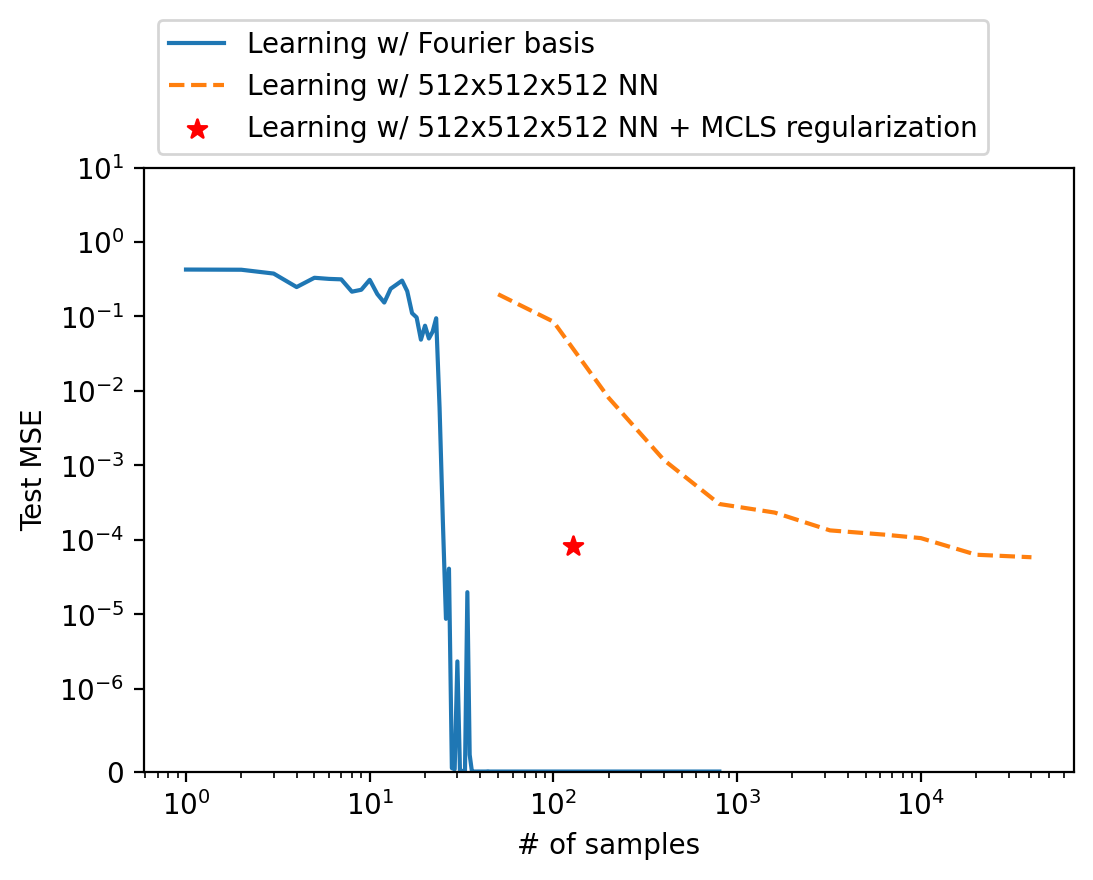

In [39]:
plt.figure(dpi=200)


def plot_key(key: str, **plt_kwargs):
    plt.plot(DATA[key].ns, DATA[key].val_mses, **plt_kwargs)


plot_key("hf", label="Learning w/ Fourier basis")
plot_key("relu", linestyle="--", label="Learning w/ 512x512x512 NN")
# plot_key("cp16-f3-lam-1", zorder=-1, label="Learning w/ poly (deg=16) basis, high-freq-reg=1.0")
# plot_key("cp16-f3-lam-l2-1e-2", linestyle="-.", label="Learning w/ poly (deg=16) basis, L2-reg=0.01")

plt.scatter(
    [DATA["relu_reg_mh"][0]],
    [DATA["relu_reg_mh"][1].val_mse.iloc[-1]],
    marker="*", c="red", s=50,
    label="Learning w/ 512x512x512 NN + MCLS regularization"
)

# plot_key("cp12-f3-lam-1")
# plot_key("cp12-f3-lam-0", linestyle="--")

plt.xscale("log")
plt.yscale("symlog", linthresh=1e-6)
plt.ylim(0, 1e1)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1))
plt.xlabel("# of samples")
plt.ylabel("Test MSE")
